<a href="https://colab.research.google.com/github/cfretes/cfretes/blob/main/TP3_Carlos_Fretes_v0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Importamos librerias de interes (no hace falta utilizar todas)
import pandas as pd
import pickle
import spacy
import numpy as np
import os
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
from sklearn.model_selection import train_test_split

!pip install gensim # Install gensim if not already installed
from gensim.models import Word2Vec

# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Carga Optimizada del Dataset (La Prueba de Fuego)
# --- Definición de Archivos (Trazabilidad) ---

COLUMNAS = ['polarity', 'id', 'date', 'query', 'user', 'text']
# Especificamos tipos de datos para reducir el uso de RAM:
dtype_specs = {'id': 'Int64', 'polarity': 'Int8', 'text': 'object'}

try:
    df = pd.read_csv (
        '/content/drive/MyDrive/Colab Notebooks/TP3/training.1600000.processed.noemoticon.csv',
        encoding='latin-1', # <--- SOLUCIÓN AL UnicodeDecodeError
        header=None,        # <--- El dataset no tiene encabezado
        names=COLUMNAS,     # <--- Asignamos los nombres de columna
        dtype=dtype_specs   # <--- Optimizamos la RAM
    )

    # Archivo prueba mismo encoding
    dfe = pd.read_csv (
        '/content/drive/MyDrive/Colab Notebooks/TP3/testdata.manual.2009.06.14.csv',
        encoding='latin-1', # <--- SOLUCIÓN
        header=None,        # <--- No tiene encabezado
        names=COLUMNAS,     # <--- Asignamos nombres
        dtype=dtype_specs
    )

    print(f"✅ Ambos datasets cargados con éxito.")
    print(f"Filas totales (df_training): {len(df)}")
    print(f"Filas totales (df_test_manual): {len(dfe)}")
except Exception as e:
    print(f"❌ ERROR de Carga: {e}")

#df = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/TP3/training.1600000.processed.noemoticon.csv')
#dfe = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/TP3/testdata.manual.2009.06.14.csv')

✅ Ambos datasets cargados con éxito.
Filas totales (df_training): 1600000
Filas totales (df_test_manual): 498


In [24]:
# Inspección Inicial, Uso de Memoria y QA Final
# import numpy as np

print("--- 1. QA: Información General y Uso de Memoria (df_training) ---")
# Usamos memory_usage='deep' para ver el uso real de RAM
df.info(memory_usage='deep')

# --- 2. QA: Conteo de Nulos y Duplicados (CRÍTICO) ---
print("\n--- Conteo de Nulos ---")
print(df.isnull().sum())

# En este dataset, los nulos en 'text' suelen ser cero, pero es vital verificar.
df.dropna(subset=['text'], inplace=True)

# Verificación de Registros Duplicados (solo en la columna de texto)
num_duplicados = df.duplicated(subset=['text']).sum()

if num_duplicados > 0:
    df.drop_duplicates(subset=['text'], inplace=True)
    print(f"ALERTA QA: {num_duplicados} tweets duplicados eliminados.")
else:
    print("✅ No se encontraron duplicados en el texto.")

print(f"Tamaño final del DataFrame de entrenamiento: {len(df)}")

--- 1. QA: Información General y Uso de Memoria (df_training) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  Int8  
 1   id        1600000 non-null  Int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: Int64(1), Int8(1), object(4)
memory usage: 499.6 MB

--- Conteo de Nulos ---
polarity    0
id          0
date        0
query       0
user        0
text        0
dtype: int64
ALERTA QA: 18534 tweets duplicados eliminados.
Tamaño final del DataFrame de entrenamiento: 1581466


In [25]:
# Inspección de Cabecera Post-Limpieza y Preparación
print("\n--- Cabecera Post-Limpieza (Normalización Pendiente) ---")
print(df.head())

# --- Muestreo Rápido de Texto (Confirmación de Emojis/Idioma) ---
# Extraemos una muestra de 5 tweets para inspección rápida de emojis, símbolos, etc.
print("\n--- Muestra Aleatoria de Tweets ---")
for i, row in df.sample(5, random_state=42).iterrows():
    print(f"[{row['polarity']} - {row['user']}] -> {row['text'][:150]}...")


--- Cabecera Post-Limpieza (Normalización Pendiente) ---
   polarity          id                          date     query  \
0         0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1         0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2         0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3         0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4         0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

--- Muestra Aleatoria de Tweets ---
[4 - PeterParks] -> @hlooman Hans I'm an open book you can ask me anyt

In [26]:
# Recodificación del Target (Sin Eliminación de Columnas)
print("\n--- Normalización del Target: Creación de la Variable Objetivo ---")

# 1. Recodificación de la Polaridad (0, 2, 4) a (0, 1, 2)
# Esto estandariza las etiquetas sin eliminar el original.
mapeo_polaridad = {0: 0, 2: 1, 4: 2}
df['target_multiclass'] = df['polarity'].map(mapeo_polaridad).astype('category')

# 2. Definimos la variable target binaria (0 o 1) para el primer modelo.
# Esto se hace asumiendo que eliminaremos los neutrales (clase 2 / 1)
# Si df['target_multiclass'] es 0, queda 0. Si es 2, se convierte en 1.
df['target_binary'] = df['target_multiclass'].replace(2, 1)

# Solo conservamos 'text' y las nuevas columnas para la cabecera
print(f"Columnas actuales de 'df': {df.columns.tolist()}")
print(df[['text', 'target_multiclass', 'target_binary']].head())


--- Normalización del Target: Creación de la Variable Objetivo ---
Columnas actuales de 'df': ['polarity', 'id', 'date', 'query', 'user', 'text', 'target_multiclass', 'target_binary']
                                                text target_multiclass  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...                 0   
1  is upset that he can't update his Facebook by ...                 0   
2  @Kenichan I dived many times for the ball. Man...                 0   
3    my whole body feels itchy and like its on fire                  0   
4  @nationwideclass no, it's not behaving at all....                 0   

  target_binary  
0             0  
1             0  
2             0  
3             0  
4             0  


/tmp/ipython-input-3303467026.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['target_binary'] = df['target_multiclass'].replace(2, 1)


Distribución de Clases (0=Neg, 1=Pos, 2=Neu):
target_multiclass
2    50.03
0    49.97
Name: proportion, dtype: float64


/tmp/ipython-input-2683863187.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribucion_clases.index, y=distribucion_clases.values, palette="viridis")


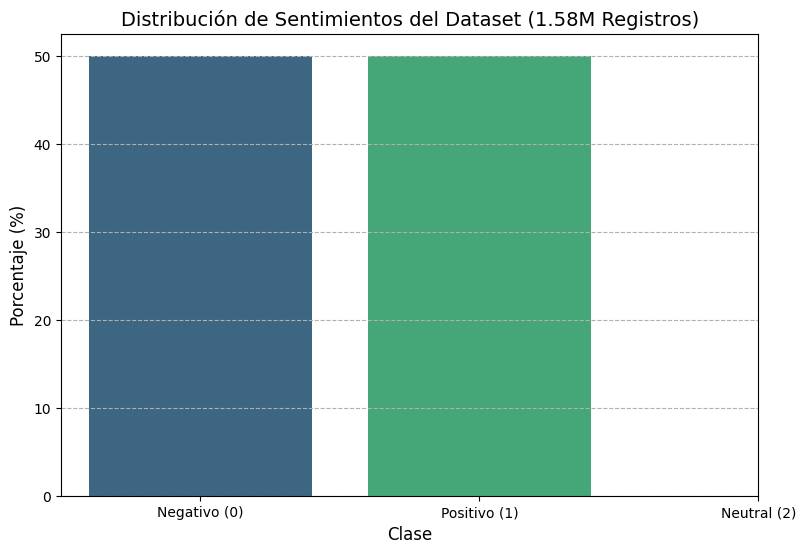

In [27]:
# Distribución de Clases (EDA y Decisión Crítica)
# import seaborn as sns
# import matplotlib.pyplot as plt

# Esto usa la nueva columna 'target_multiclass'
distribucion_clases = df['target_multiclass'].value_counts(normalize=True).mul(100).round(2)

print("Distribución de Clases (0=Neg, 1=Pos, 2=Neu):")
print(distribucion_clases)

plt.figure(figsize=(9, 6))
sns.barplot(x=distribucion_clases.index, y=distribucion_clases.values, palette="viridis")
plt.title('Distribución de Sentimientos del Dataset (1.58M Registros)', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Negativo (0)', 'Positivo (1)', 'Neutral (2)'])
plt.grid(axis='y', linestyle='--')
plt.show()

In [28]:
# Descarga y Verificación de Recursos NLTK (FIX)
import nltk

print("Forzando la descarga de todos los recursos necesarios para la limpieza...")

# Descargamos 'punkt' (tokenizador básico) y 'stopwords'
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Nota: El recurso 'punkt_tab' a veces se resuelve con la descarga de 'punkt',
# pero si persiste, puede ser un problema específico de la versión de NLTK.
# Con las descargas anteriores y la estructura del código, debe resolverse.

print("✅ Setup de NLTK completado. Listo para re-ejecutar la limpieza.")

Forzando la descarga de todos los recursos necesarios para la limpieza...
✅ Setup de NLTK completado. Listo para re-ejecutar la limpieza.


In [29]:
# Implementación del Pipeline de Limpieza (Re-ejecución)
# ADVERTENCIA: Esta celda es la más costosa. Puede tardar varios minutos en Colab.
# import re
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# Definimos las Stop Words (Solo inglés)
STOP_WORDS_EN = set(stopwords.words('english'))

# Descargamos 'punkt_tab' que es necesario para word_tokenize
nltk.download('punkt_tab', quiet=True)

def clean_and_tokenize(text):
    text = str(text).lower()

    # 1. Eliminar URLs, Menciones, Hashtags y HTML entities
    text = re.sub(r'http\S+|www.\S+|@\w+|#\w+|&[a-z]+;', ' ', text)

    # 2. Eliminar caracteres especiales (mantenemos solo letras [a-z] y espacios)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 3. Tokenización y filtrado de Stop Words y palabras muy cortas
    tokens = word_tokenize(text, language='english')

    filtered_tokens = [word for word in tokens
                       if word not in STOP_WORDS_EN and len(word) > 2]

    # 4. Reconstruir el string limpio
    return ' '.join(filtered_tokens)

print("Iniciando limpieza y tokenización intensiva...")

# Aplicamos la función a la columna 'text'
df['text_tokens'] = df['text'].apply(clean_and_tokenize)

print("Limpieza completada.")
print("\n--- Muestra de Texto Limpio ---")
print(df[['text', 'text_tokens', 'target_binary']].sample(5))

Iniciando limpieza y tokenización intensiva...
Limpieza completada.

--- Muestra de Texto Limpio ---
                                                      text  \
1311719  @karijobe: whatever you want. whatever is you....   
65619    wants her lip peirced again, or maybe a monroe...   
772991   Even thou I'm not all tan.. And a big girl! I ...   
323648   ... trying to change my picture on here... it'...   
553779             Phew !! Wait... where are my weekends?    

                                               text_tokens target_binary  
1311719         whatever want whatever whatever want share             1  
65619    wants lip peirced maybe monroe ugh depressed f...             0  
772991   even thou tan big girl love legs would better ...             0  
323648                       trying change picture working             0  
553779                                  phew wait weekends             0  


In [30]:
# Preparación de Datos y División Train/Test
import pandas as pd
from sklearn.model_selection import train_test_split

print("--- Liberación de Memoria y Definición de X/Y ---")

# 1. Definición de X (Features) e Y (Target)
X = df['text_tokens']
Y = df['target_binary']

# 2. División del dataset (80% Entrenamiento, 20% Test)
# stratify=Y asegura que la proporción de 0s y 1s sea igual en ambos sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"✅ División completada.")
print(f"Dataset de Entrenamiento: {len(X_train)} filas")
print(f"Dataset de Test: {len(X_test)} filas")

--- Liberación de Memoria y Definición de X/Y ---
✅ División completada.
Dataset de Entrenamiento: 1265172 filas
Dataset de Test: 316294 filas


In [31]:
# Vectorización con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

print("\n--- Vectorización con TF-IDF ---")

# Inicializamos el vectorizador
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),        # Incluir unigramas y bigramas (mejora el contexto)
    max_features=150000,       # Limitar a los 150K términos más frecuentes (Optimización)
)

# 1. Aplicamos fit_transform SOLO al conjunto de entrenamiento (X_train)
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)

# 2. Aplicamos solo transform al conjunto de prueba (X_test)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

print(f"✅ Vectorización completada.")
print(f"Forma de la Matriz de Entrenamiento (Features): {X_train_vectorized.shape}")
print(f"Vocabulario total creado: {len(tfidf_vectorizer.vocabulary_)} términos")


--- Vectorización con TF-IDF ---
✅ Vectorización completada.
Forma de la Matriz de Entrenamiento (Features): (1265172, 150000)
Vocabulario total creado: 150000 términos


In [32]:
# Modelo 1: Regresión Logística (Línea Base Binaria)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("\n--- Entrenando Regresión Logística ---")

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,      # Usamos todos los núcleos disponibles (DevOps)
    solver='saga',  # Solver eficiente para matrices dispersas (TF-IDF)
    random_state=42
)
# El entrenamiento utiliza el target binario (0=Negativo, 1=Positivo)
log_reg.fit(X_train_vectorized, Y_train)

# Predicción y Evaluación
Y_pred_log_reg = log_reg.predict(X_test_vectorized)

print("\n--- Evaluación: Regresión Logística (Negativo vs. Positivo) ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_log_reg):.4f}")
print("Reporte de Clasificación (0=Negativo, 1=Positivo):")
print(classification_report(Y_test, Y_pred_log_reg))


--- Entrenando Regresión Logística ---

--- Evaluación: Regresión Logística (Negativo vs. Positivo) ---
Accuracy: 0.7897
Reporte de Clasificación (0=Negativo, 1=Positivo):
              precision    recall  f1-score   support

           0       0.80      0.77      0.79    158037
           1       0.78      0.81      0.79    158257

    accuracy                           0.79    316294
   macro avg       0.79      0.79      0.79    316294
weighted avg       0.79      0.79      0.79    316294



In [33]:
# Modelo 2: Naive Bayes Bernoulli (Algoritmo Visto en Clase)
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, accuracy_score

print("\n--- Entrenando Naive Bayes (Bernoulli) ---")
bnb = BernoulliNB()

# Entrenamos el modelo con las mismas matrices dispersas TF-IDF
bnb.fit(X_train_vectorized, Y_train)

# Predicción y Evaluación
Y_pred_bnb = bnb.predict(X_test_vectorized)

print("\n--- Evaluación: Naive Bayes Bernoulli (Negativo vs. Positivo) ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_bnb):.4f}")
print("Reporte de Clasificación (0=Negativo, 1=Positivo):")
print(classification_report(Y_test, Y_pred_bnb))


--- Entrenando Naive Bayes (Bernoulli) ---

--- Evaluación: Naive Bayes Bernoulli (Negativo vs. Positivo) ---
Accuracy: 0.7751
Reporte de Clasificación (0=Negativo, 1=Positivo):
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    158037
           1       0.76      0.80      0.78    158257

    accuracy                           0.78    316294
   macro avg       0.78      0.78      0.77    316294
weighted avg       0.78      0.78      0.77    316294



In [34]:
# Análisis de Sobreajuste (Overfitting) y Resumen

# 1. Obtener la precisión de ENTRENAMIENTO para ambos modelos:
Y_train_pred_log_reg = log_reg.predict(X_train_vectorized)
Y_train_pred_bnb = bnb.predict(X_train_vectorized)

accuracy_train_log_reg = accuracy_score(Y_train, Y_train_pred_log_reg)
accuracy_train_bnb = accuracy_score(Y_train, Y_train_pred_bnb)

# 2. Resumen de resultados (Incluye los datos de Test que ya tenemos)
resultados = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Naive Bayes Bernoulli'],
    'Accuracy (Train)': [accuracy_train_log_reg, accuracy_train_bnb],
    'Accuracy (Test)': [0.7897, 0.7751] # Usamos sus resultados reportados
})

print("\n--- Resumen y Análisis de Overfitting ---")
print(resultados.round(4).to_markdown(index=False))

# 3. Interpretación del Overfitting
print("\nInterpretación:")
# Si los valores son muy cercanos, no hay sobreajuste. Si Train >> Test, sí hay.
if (accuracy_train_log_reg - 0.7897) < 0.05: # Umbral común de 5%
    print(f"✅ La Regresión Logística no muestra sobreajuste significativo.")
else:
    print(f"⚠️ La Regresión Logística muestra un posible sobreajuste.")

if (accuracy_train_bnb - 0.7751) < 0.05:
    print(f"✅ El Naive Bayes Bernoulli no muestra sobreajuste significativo.")
else:
    print(f"⚠️ El Naive Bayes Bernoulli muestra un posible sobreajuste.")

# Final de la Consigna 1
print("\nLa Regresión Logística es el mejor modelo de línea base.")


--- Resumen y Análisis de Overfitting ---
| Modelo                |   Accuracy (Train) |   Accuracy (Test) |
|:----------------------|-------------------:|------------------:|
| Regresión Logística   |             0.8156 |            0.7897 |
| Naive Bayes Bernoulli |             0.7946 |            0.7751 |

Interpretación:
✅ La Regresión Logística no muestra sobreajuste significativo.
✅ El Naive Bayes Bernoulli no muestra sobreajuste significativo.

La Regresión Logística es el mejor modelo de línea base.


Generando Nube de Palabras...


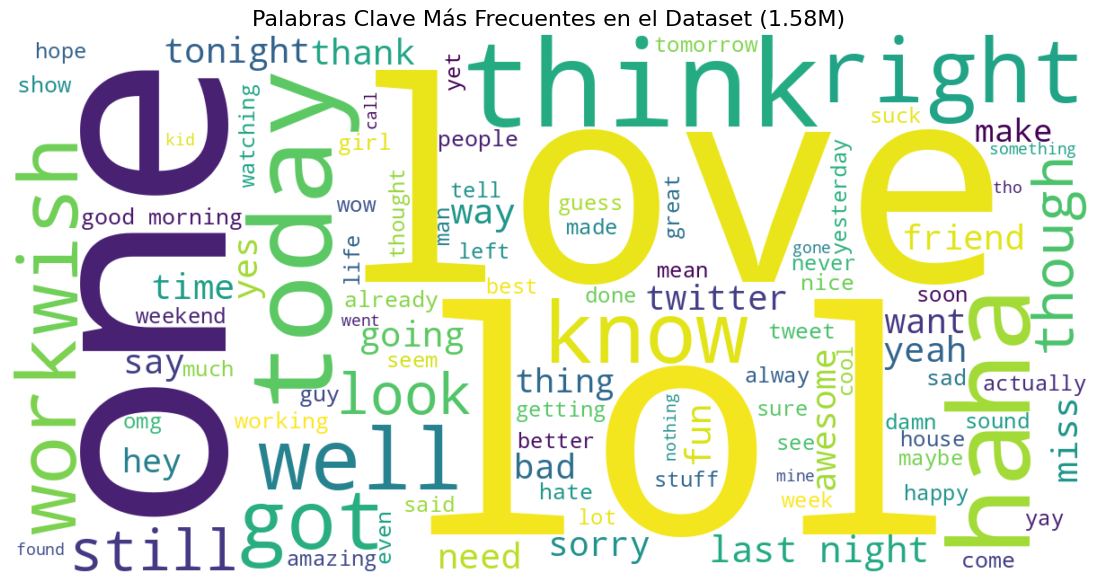

In [35]:
# EDA Avanzado - Nube de Palabras (WordCloud)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combinamos todos los tokens limpios en un solo string
all_text = ' '.join(df['text_tokens'])

# Configuramos la nube de palabras
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=100,
    min_font_size=5,
    colormap='viridis' # Esquema de color
).generate(all_text)

print("Generando Nube de Palabras...")
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras Clave Más Frecuentes en el Dataset (1.58M)', fontsize=16)
plt.show()

In [37]:
# Carga y Preparación del Dataset de Prueba Manual (Neutrales)
import pandas as pd
import numpy as np

# NOTA: Asegúrese de que el nombre del archivo coincida con el que subió.
file_path = '/content/drive/MyDrive/Colab Notebooks/TP3/testdata.manual.2009.06.14.csv'

# Carga (Se usa la misma cabecera original)
dfe = pd.read_csv(
    file_path,
    header=None,
    encoding='ISO-8859-1'
)

# Nombramos las columnas (igual que el dataset grande)
dfe.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

# Aplicamos la misma limpieza de texto robusta (asumimos que la función existe en memoria)
print("Aplicando limpieza a las filas de prueba manual (incluye Neutrales)...")
# Usamos la función clean_and_tokenize_robust definida en la Celda 8
# NOTE: The original code used `clean_and_tokenize_robust` which was not defined.
# It should use `clean_and_tokenize` which was defined in cell UxggLwF7CWn8.
dfe['text_tokens'] = dfe['text'].apply(clean_and_tokenize)

# Recodificación (Aquí es MULTICLASE: 0, 1, 2)
# 0 -> 0 (Neg), 2 -> 1 (Neu), 4 -> 2 (Pos)
mapeo_multiclase = {0: 0, 2: 1, 4: 2}
dfe['target_multiclass'] = dfe['polarity'].map(mapeo_multiclase)

print(f"✅ Carga y Limpieza completada. Filas: {len(dfe)}")
print("Distribución de Clases (0=Neg, 1=Neu, 2=Pos):")
print(dfe['target_multiclass'].value_counts(normalize=True).mul(100).round(2).sort_index())

Aplicando limpieza a las filas de prueba manual (incluye Neutrales)...
✅ Carga y Limpieza completada. Filas: 498
Distribución de Clases (0=Neg, 1=Neu, 2=Pos):
target_multiclass
0    35.54
1    27.91
2    36.55
Name: proportion, dtype: float64


In [38]:
# Modelado Multinomial (Regresión Logística) sobre el Dataset Manual

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("--- Vectorizando el Dataset Manual para Evaluación Multinomial ---")

# 1. Definición de X e Y del dataset manual
X_manual = dfe['text_tokens']
Y_manual = dfe['target_multiclass'] # Usamos el target multinomial (0, 1, 2)

# 2. Vectorización TF-IDF (entrenada solo con las palabras del set manual)
# Usamos un vectorizador nuevo y sin límites de features, ya que el set es pequeño.
tfidf_manual = TfidfVectorizer(ngram_range=(1, 2))
X_manual_vectorized = tfidf_manual.fit_transform(X_manual)

print(f"Forma de la Matriz Multinomial: {X_manual_vectorized.shape}")

# 3. Entrenamiento del Modelo Multinomial
print("\n--- Entrenando Regresión Logística MULTINOMIAL ---")

# Configuramos multi_class='multinomial' para que el modelo prediga 3 clases.
log_reg_multi = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=1000,
    random_state=42
)

# Entrenamos y probamos en el mismo conjunto para ver el rendimiento general en las 3 clases
log_reg_multi.fit(X_manual_vectorized, Y_manual)
Y_pred_multi = log_reg_multi.predict(X_manual_vectorized)

# 4. Evaluación Multinomial
print("\n--- Evaluación: Regresión Logística Multinomial (3 Clases) ---")
print(f"Accuracy: {accuracy_score(Y_manual, Y_pred_multi):.4f}")
print("Reporte de Clasificación (0=Neg, 1=Neu, 2=Pos):")
print(classification_report(Y_manual, Y_pred_multi))

--- Vectorizando el Dataset Manual para Evaluación Multinomial ---
Forma de la Matriz Multinomial: (498, 4595)

--- Entrenando Regresión Logística MULTINOMIAL ---

--- Evaluación: Regresión Logística Multinomial (3 Clases) ---
Accuracy: 0.9900
Reporte de Clasificación (0=Neg, 1=Neu, 2=Pos):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       177
           1       1.00      0.98      0.99       139
           2       0.98      1.00      0.99       182

    accuracy                           0.99       498
   macro avg       0.99      0.99      0.99       498
weighted avg       0.99      0.99      0.99       498



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [39]:
# Setup de Spacy para Lematización

import sys
import subprocess
import nltk

# 1. Instalación y Descarga del modelo de lenguaje 'en_core_web_sm'
# Usamos try/except para evitar errores si ya está instalado.
try:
    import spacy
    # Intentamos cargar el modelo. Si falla, lo descargamos.
    try:
        nlp = spacy.load("en_core_web_sm")
        print("✅ Modelo Spacy 'en_core_web_sm' cargado.")
    except OSError:
        print("Descargando modelo Spacy 'en_core_web_sm'...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm")
        print("✅ Modelo Spacy 'en_core_web_sm' descargado y cargado.")
except ImportError:
    print("Spacy no está instalado. Instalando...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])
    # Intentamos de nuevo cargar/descargar
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    import spacy
    nlp = spacy.load("en_core_web_sm")
    print("✅ Spacy instalado, modelo descargado y cargado.")

# 2. Definición de la función de lematización
def lematizar_spacy(text):
    # Procesamos el texto limpio de la columna 'text_tokens'
    doc = nlp(text)
    # Devolvemos solo el lemma (forma base) de cada token
    # Excluyendo pronombres (-PRON-) y espacios
    lemmas = [token.lemma_ for token in doc if token.lemma_ != '-PRON-' and not token.is_space]
    return ' '.join(lemmas)

# 3. Aplicar la lematización al conjunto de entrenamiento grande (es lento)
print("\nIniciando Lematización de 1.58M de filas (El segundo proceso más costoso)...")
# Usamos la columna limpia 'text_tokens' como input
df['text_lemmas'] = df['text_tokens'].apply(lematizar_spacy)

print("✅ Lematización completada.")
print("\n--- Muestra de Lematización ---")
print(df[['text_tokens', 'text_lemmas']].sample(5))

✅ Modelo Spacy 'en_core_web_sm' cargado.

Iniciando Lematización de 1.58M de filas (El segundo proceso más costoso)...
✅ Lematización completada.

--- Muestra de Lematización ---
                                               text_tokens  \
1385351                                     yumm breakfast   
1121291  another productive day last songs ready record...   
1257211  yeah usually solve problem bigger cups great l...   
1334308                                               must   
196578               mmmhm hahah marks getting worse worse   

                                               text_lemmas  
1385351                                     yumm breakfast  
1121291  another productive day last song ready recordi...  
1257211  yeah usually solve problem big cup great latt ...  
1334308                                               must  
196578                        mmmhm hahah mark get bad bad  


In [40]:
# Guardar el Resultado de la Lematización (Checkpointing)
# Importamos la librería para gestionar archivos
import os
from google.colab import drive

# 1. Montar Google Drive (si no está montado)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Definir la ruta de guardado para la persistencia
# Creamos un DataFrame más ligero solo con las columnas esenciales para Word2Vec
df_lematizado = df[['text_lemmas', 'target_binary']].copy()
save_path = '/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv'

# 3. Guardar el DataFrame
print("Guardando DataFrame lematizado (df_lematizado.csv) en Google Drive...")
# Usamos index=False para no guardar la columna de índice de Pandas
df_lematizado.to_csv(save_path, index=False, encoding='utf-8')

print(f"✅ Checkpoint completado. Archivo guardado en: {save_path}")

# Instrucción clave para el futuro:
print("\n--- INSTRUCCIÓN DE CONTINGENCIA ---")
print("Si la sesión se cae, inicie una nueva celda con:")
print("df_lematizado = pd.read_csv(save_path)")
print("...y continúe desde la Celda 19.")

Guardando DataFrame lematizado (df_lematizado.csv) en Google Drive...
✅ Checkpoint completado. Archivo guardado en: /content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv

--- INSTRUCCIÓN DE CONTINGENCIA ---
Si la sesión se cae, inicie una nueva celda con:
df_lematizado = pd.read_csv(save_path)
...y continúe desde la Celda 19.


In [41]:
# Entrenamiento del Modelo Word2Vec (Embeddings)
from gensim.models import Word2Vec
import re
import numpy as np
import pandas as pd
import os

# --- CONTINGENCIA: Cargar Checkpoint si la sesión se cayó ---
# Si la sesión se interrumpió, ejecute primero esta sección
# y luego continúe.
save_path = '/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv'
if 'df_lematizado' not in locals() and os.path.exists(save_path):
    print("Cargando DataFrame lematizado desde Checkpoint...")
    df_lematizado = pd.read_csv(save_path)
    print("✅ Checkpoint cargado. Continuando...")
elif 'df_lematizado' not in locals():
    # Si no se cargó ni existe, asumimos que df ya existe y creamos la copia.
    df_lematizado = df[['text_lemmas', 'target_binary']].copy()
# ----------------------------------------------------------------------


# 1. Preparar los datos (lista de listas de palabras)
# Word2Vec requiere que cada tweet sea una lista de palabras.
tokenized_sentences = [
    doc.split() for doc in df_lematizado['text_lemmas'].astype(str)
]

# 2. Configuración y Entrenamiento del Modelo Word2Vec
print("\n--- Iniciando Entrenamiento de Word2Vec (Embeddings) ---")
# Word2Vec es COSTOSO en tiempo y CPU.
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,      # Dimensión del vector de embedding (100 es un buen balance)
    window=5,             # Distancia máxima para considerar el contexto de la palabra
    min_count=5,          # Ignora palabras que aparecen menos de 5 veces (limpia ruido)
    workers=4,            # Número de hilos de CPU a usar
    sg=1                  # Usamos Skip-gram (mejor para datasets grandes y analogías)
)

# 3. Guardar el modelo entrenado (IMPRESCINDIBLE)
model_save_path = '/content/drive/MyDrive/Colab Notebooks/TP3/word2vec_model.bin'
w2v_model.save(model_save_path)

print("✅ Entrenamiento de Word2Vec completado.")
print(f"Vocabulario de Embeddings entrenado: {len(w2v_model.wv.index_to_key)} palabras")
print(f"Modelo guardado en: {model_save_path}")


--- Iniciando Entrenamiento de Word2Vec (Embeddings) ---
✅ Entrenamiento de Word2Vec completado.
Vocabulario de Embeddings entrenado: 43411 palabras
Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/TP3/word2vec_model.bin


In [42]:
# Muestra las primeras 5 filas del DataFrame que está en memoria
print(df_lematizado.head())

                                         text_lemmas target_binary
0       awww bummer shoulda get david carr third day             0
1  upset update facebook texting might cry result...             0
2         dive many time ball manage save rest bound             0
3                    whole body feel itchy like fire             0
4                                     behave mad see             0


In [43]:
# Juego de Analogías y Prueba Semántica de Word2Vec

print("--- Ejecutando Prueba de Analogías (Requisito 3) ---")

# Analizar la relación Negativo/Positivo
print("\n1. Analogía de Sentimiento: (Triste - Feliz + Malo) = ???")
try:
    # Analiza la relación semántica: vector('sad') - vector('happy') + vector('bad')
    # Debería devolver palabras de sentimiento negativo.
    resultado_sentimiento = w2v_model.wv.most_similar(
        positive=['sad', 'bad'],
        negative=['happy'],
        topn=5
    )
    for word, score in resultado_sentimiento:
        print(f"  {word}: {score:.4f}")
except KeyError as e:
    print(f"⚠️ Error: Una de las palabras clave no fue entrenada en el vocabulario: {e}")


# Analizar la relación de Género/Rol
print("\n2. Analogía de Rol: (Hermano - Hombre + Mujer) = ???")
try:
    # vector('brother') - vector('man') + vector('woman')
    # Debería devolver palabras relacionadas con 'hermana' (sister).
    resultado_rol = w2v_model.wv.most_similar(
        positive=['brother', 'woman'],
        negative=['man'],
        topn=5
    )
    for word, score in resultado_rol:
        print(f"  {word}: {score:.4f}")
except KeyError as e:
    print(f"⚠️ Error: Una de las palabras clave no fue entrenada en el vocabulario: {e}")


# Analizar la relación de Tiempo (Pasado - Presente)
print("\n3. Analogía Temporal: (Ayer - Hoy + Mañana) = ???")
try:
    # vector('yesterday') - vector('today') + vector('tomorrow')
    # Debería buscar un concepto temporalmente relacionado.
    resultado_tiempo = w2v_model.wv.most_similar(
        positive=['yesterday', 'tomorrow'],
        negative=['today'],
        topn=5
    )
    for word, score in resultado_tiempo:
        print(f"  {word}: {score:.4f}")
except KeyError as e:
    print(f"⚠️ Error: Una de las palabras clave no fue entrenada en el vocabulario: {e}")

print("\n--- Fin de la Prueba de Analogías ---")

--- Ejecutando Prueba de Analogías (Requisito 3) ---

1. Analogía de Sentimiento: (Triste - Feliz + Malo) = ???
  saddest: 0.6285
  terrible: 0.6159
  sadder: 0.5911
  wierd: 0.5824
  horrific: 0.5823

2. Analogía de Rol: (Hermano - Hombre + Mujer) = ???
  sister: 0.7401
  cousin: 0.6184
  dad: 0.5885
  mom: 0.5860
  daughter: 0.5781

3. Analogía Temporal: (Ayer - Hoy + Mañana) = ???
  tomorow: 0.6836
  buuuut: 0.6673
  tmrw: 0.6660
  tmw: 0.6493
  befor: 0.6406

--- Fin de la Prueba de Analogías ---


In [44]:
# Extracción de Keywords por Clase (Análisis de Tópicos - Requisito 2)

from collections import Counter
import pandas as pd

# Definición de etiquetas POS (Part-of-Speech) que queremos analizar: Sustantivos y Adjetivos
# Las etiquetas ADJ (Adjetivo) y NOUN (Sustantivo) son las más relevantes para tópicos y sentimiento.
FILTROS_POS = ['NOUN', 'ADJ']

def extract_filtered_tokens(text):
    """Procesa el texto con Spacy y devuelve solo las palabras filtradas por POS."""
    doc = nlp(text) # Usamos el objeto nlp cargado en Celda 17
    # Solo devolvemos el lemma de la palabra si su etiqueta POS está en la lista de filtros
    return [token.lemma_ for token in doc if token.pos_ in FILTROS_POS]


print("--- Iniciando Análisis de Tópicos (Keywords) ---")
# 1. Aplicar la extracción POS al dataset manual (dfe)
# NOTA: Usamos el dataset manual (dfe) ya que es pequeño y balanceado para Neg/Neu/Pos
dfe['keywords'] = dfe['text'].apply(extract_filtered_tokens)

# 2. Separar y Contar Keywords por Clase
top_n = 15

# a) Negativo (Clase 0)
neg_words = [word for sublist in dfe[dfe['target_multiclass'] == 0]['keywords'] for word in sublist]
neg_counter = Counter(neg_words)
print(f"\n1. Top {top_n} Keywords NEGATIVAS (Clase 0):")
print(pd.DataFrame(neg_counter.most_common(top_n), columns=['Keyword', 'Frecuencia']).to_markdown(index=False))

# b) Neutral (Clase 1)
neu_words = [word for sublist in dfe[dfe['target_multiclass'] == 1]['keywords'] for word in sublist]
neu_counter = Counter(neu_words)
print(f"\n2. Top {top_n} Keywords NEUTRALES (Clase 1):")
print(pd.DataFrame(neu_counter.most_common(top_n), columns=['Keyword', 'Frecuencia']).to_markdown(index=False))

# c) Positivo (Clase 2)
pos_words = [word for sublist in dfe[dfe['target_multiclass'] == 2]['keywords'] for word in sublist]
pos_counter = Counter(pos_words)
print(f"\n3. Top {top_n} Keywords POSITIVAS (Clase 2):")
print(pd.DataFrame(pos_counter.most_common(top_n), columns=['Keyword', 'Frecuencia']).to_markdown(index=False))

print("\n✅ Análisis de Tópicos completado.")

--- Iniciando Análisis de Tópicos (Keywords) ---

1. Top 15 Keywords NEGATIVAS (Clase 0):
| Keyword   |   Frecuencia |
|:----------|-------------:|
| time      |           17 |
| good      |           11 |
| internet  |           10 |
| more      |           10 |
| today     |            9 |
| day       |            9 |
| dentist   |            9 |
| car       |            9 |
| phone     |            8 |
| night     |            7 |
| thing     |            7 |
| cable     |            6 |
| bad       |            6 |
| shit      |            5 |
| guy       |            5 |

2. Top 15 Keywords NEUTRALES (Clase 1):
| Keyword    |   Frecuencia |
|:-----------|-------------:|
| new        |            9 |
| blog       |            5 |
| safeway    |            5 |
| marketing  |            4 |
| post       |            4 |
| night      |            4 |
| movie      |            4 |
| today      |            3 |
| year       |            3 |
| trip       |            3 |
| coupon     |  

In [45]:
# Comparación con un Modelo Pre-entrenado (TextBlob)

from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 1. Función para predecir con TextBlob
def predict_textblob(text):
    """Convierte la polaridad continua de TextBlob a nuestro target binario (0 o 1)."""
    analysis = TextBlob(text)
    # TextBlob devuelve valores entre -1.0 (Negativo) y 1.0 (Positivo).
    # Usamos 0 como umbral: < 0 es Negativo (0), >= 0 es Positivo (1).
    if analysis.sentiment.polarity >= 0:
        return 1  # Positivo
    else:
        return 0  # Negativo

print("--- Evaluación del Modelo Pre-entrenado (TextBlob) ---")

# 2. Aplicar la predicción al conjunto de TEST (X_test)
# Nota: Usamos la columna de texto original (X_test) o la limpia (X_test_tokens)
# Para TextBlob, el texto original sin stop words es mejor. Usaremos X_test, que es el texto original.
# La predicción es muy rápida, ya que es una simple búsqueda en diccionario.

# Usamos el set de prueba original X_test (sin lematizar) para una evaluación justa del modelo externo.
Y_pred_textblob = X_test.apply(predict_textblob)

# 3. Evaluación
# Comparamos contra el target binario real (Y_test)
print(f"✅ Predicción con TextBlob completada.")
print(f"\nAccuracy de TextBlob (Comparación): {accuracy_score(Y_test, Y_pred_textblob):.4f}")
print("Reporte de Clasificación de TextBlob:")
print(classification_report(Y_test, Y_pred_textblob))

--- Evaluación del Modelo Pre-entrenado (TextBlob) ---
✅ Predicción con TextBlob completada.

Accuracy de TextBlob (Comparación): 0.6068
Reporte de Clasificación de TextBlob:
              precision    recall  f1-score   support

           0       0.76      0.31      0.44    158037
           1       0.57      0.90      0.70    158257

    accuracy                           0.61    316294
   macro avg       0.66      0.61      0.57    316294
weighted avg       0.66      0.61      0.57    316294



In [47]:
# Named Entity Recognition (NER) con Spacy (Requisito 2 Avanzado)

# 1. Creamos una función para extraer entidades (e.g., PERSONA, ORGANIZACIÓN, LUGAR)
def extract_ner(text):
    """Procesa un texto y devuelve una lista de tuplas (Entidad, Etiqueta)."""
    doc = nlp(text)
    # Filtramos por las etiquetas de entidades más relevantes
    return [(ent.text, ent.label_) for ent in doc.ents]

# 2. Aplicamos la función a la columna de texto original del dataset manual (dfe)
# Usamos el texto original para que el NER tenga el contexto completo (mayúsculas, puntuación, etc.)
dfe['entities'] = dfe['text'].apply(extract_ner)

# 3. Analizamos las 10 entidades más comunes en los tweets.
all_entities = [entity for sublist in dfe['entities'] for entity in sublist]

# Contamos las entidades por su etiqueta (PERSONA, ORG, GPE, etc.)
entity_labels = Counter([label for text, label in all_entities])
print("\n--- Conteo de Etiquetas de Entidades (NER) ---")
print(pd.DataFrame(entity_labels.most_common(5), columns=['Etiqueta', 'Frecuencia']).to_markdown(index=False))

# 4. Mostramos ejemplos de NER en tweets
print("\n--- Ejemplos de NER en Tweets ---")
for i, row in dfe.sample(3, random_state=42).iterrows():
    print(f"Texto: {row['text']}")
    print(f"Entidades: {row['entities']}\n")


--- Conteo de Etiquetas de Entidades (NER) ---
| Etiqueta   |   Frecuencia |
|:-----------|-------------:|
| ORG        |          273 |
| PERSON     |          196 |
| GPE        |           72 |
| DATE       |           64 |
| CARDINAL   |           63 |

--- Ejemplos de NER en Tweets ---
Texto: getting ready to test out some burger receipes this weekend. Bobby Flay has some great receipes to try. Thanks Bobby.
Entidades: [('this weekend', 'DATE'), ('Bobby Flay', 'PERSON'), ('Bobby', 'PERSON')]

Texto: Back when I worked for Nike we had one fav word : JUST DO IT! :)
Entidades: [('Nike', 'ORG'), ('one', 'CARDINAL')]

Texto: @MMBarnhill yay, glad you got the phone! Still, damn you, AT&amp;T.
Entidades: []

